In [1]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("noshowappointments.csv")


In [2]:
df.columns = df.columns.str.strip().str.lower().str.replace('-', '_')


In [3]:
df.head()

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [4]:
df['scheduledday'] = pd.to_datetime(df['scheduledday'])
df['appointmentday'] = pd.to_datetime(df['appointmentday'])

# Feature: waiting days
df['waiting_days'] = (df['appointmentday'] - df['scheduledday']).dt.days

# Feature: day of week
df['appointment_day_of_week'] = df['appointmentday'].dt.dayofweek


In [5]:
# Encode target: 'No' = 0 (show), 'Yes' = 1 (no-show)
df['no_show'] = df['no_show'].map({'No': 0, 'Yes': 1})


In [6]:
# Remove invalid ages (negative)
df = df[df['age'] >= 0]

# Drop ID columns (optional)
df.drop(['patientid', 'appointmentid', 'scheduledday', 'appointmentday'], axis=1, inplace=True)


In [7]:
from sklearn.preprocessing import LabelEncoder

df['gender'] = LabelEncoder().fit_transform(df['gender'])  # Female=0, Male=1

# One-hot encode 'neighbourhood'
df = pd.get_dummies(df, columns=['neighbourhood'], drop_first=True)


In [8]:
print(df.info())
print(df.describe())
print(df['no_show'].value_counts(normalize=True))


<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110526
Data columns (total 91 columns):
 #   Column                                     Non-Null Count   Dtype
---  ------                                     --------------   -----
 0   gender                                     110526 non-null  int32
 1   age                                        110526 non-null  int64
 2   scholarship                                110526 non-null  int64
 3   hipertension                               110526 non-null  int64
 4   diabetes                                   110526 non-null  int64
 5   alcoholism                                 110526 non-null  int64
 6   handcap                                    110526 non-null  int64
 7   sms_received                               110526 non-null  int64
 8   no_show                                    110526 non-null  int64
 9   waiting_days                               110526 non-null  int64
 10  appointment_day_of_week         

Text(0.5, 1.0, 'Distribution of Waiting Days')

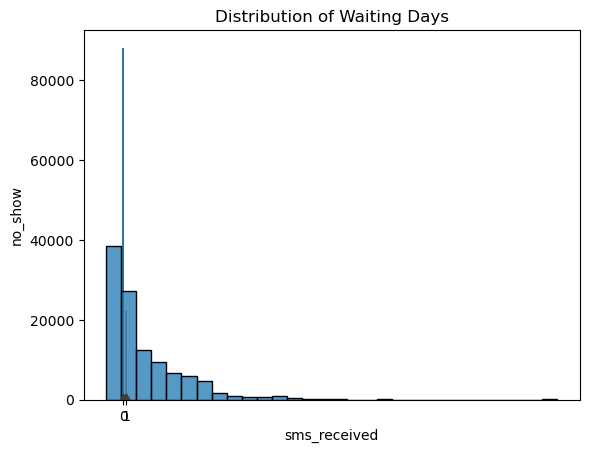

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='no_show', data=df)
plt.title("Show vs No-show Distribution")

sns.boxplot(x='no_show', y='age', data=df)
plt.title("Age Distribution by No-show")

sns.barplot(x='sms_received', y='no_show', data=df)
plt.title("Effect of SMS Reminders")

sns.histplot(df['waiting_days'], bins=30)
plt.title("Distribution of Waiting Days")


In [10]:
from sklearn.model_selection import train_test_split

X = df.drop('no_show', axis=1)
y = df['no_show']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[16374  1341]
 [ 3430   961]]
              precision    recall  f1-score   support

           0       0.83      0.92      0.87     17715
           1       0.42      0.22      0.29      4391

    accuracy                           0.78     22106
   macro avg       0.62      0.57      0.58     22106
weighted avg       0.75      0.78      0.76     22106



<Axes: title={'center': 'Feature Importance'}>

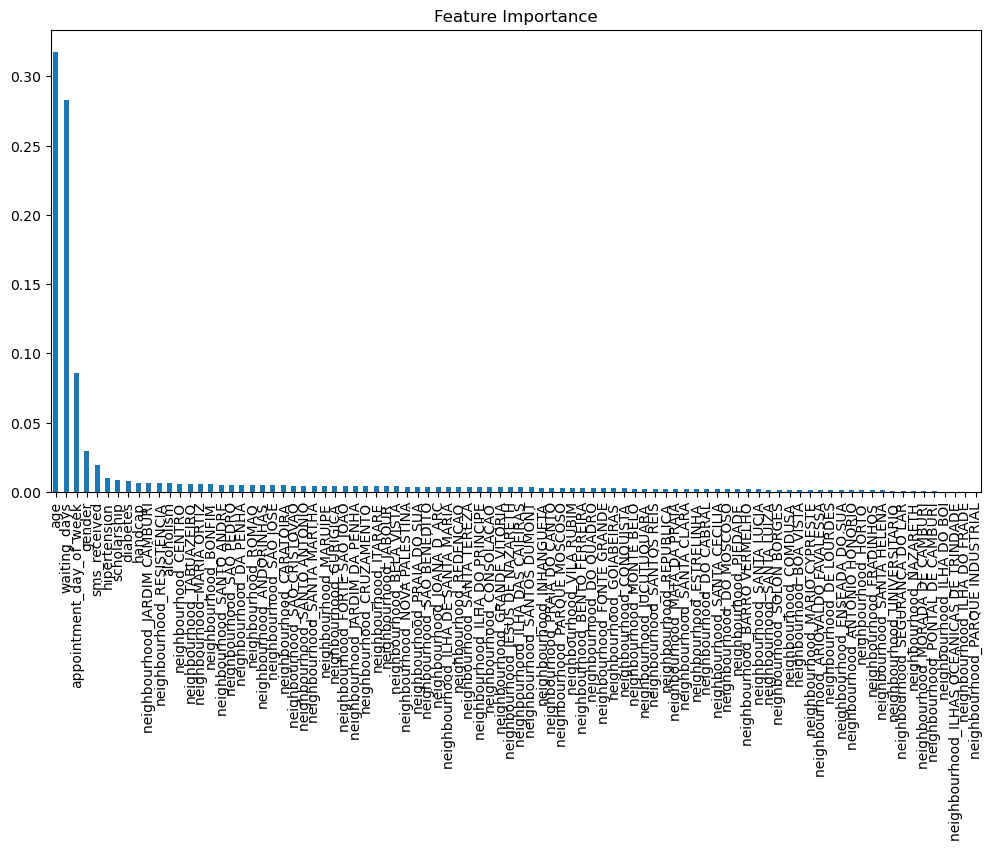

In [12]:
importances = model.feature_importances_
features = X.columns

feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)
feat_imp.plot(kind='bar', figsize=(12, 6), title='Feature Importance')


In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [15]:
# Drop target column to get features
X = df.drop('no_show', axis=1)
y = df['no_show']


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
# You can tune 'max_depth' or 'min_samples_split' for better performance
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

In [18]:
y_pred = dt_model.predict(X_test)


In [19]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7849452637293043
Confusion Matrix:
 [[16408  1307]
 [ 3447   944]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.93      0.87     17715
           1       0.42      0.21      0.28      4391

    accuracy                           0.78     22106
   macro avg       0.62      0.57      0.58     22106
weighted avg       0.75      0.78      0.76     22106



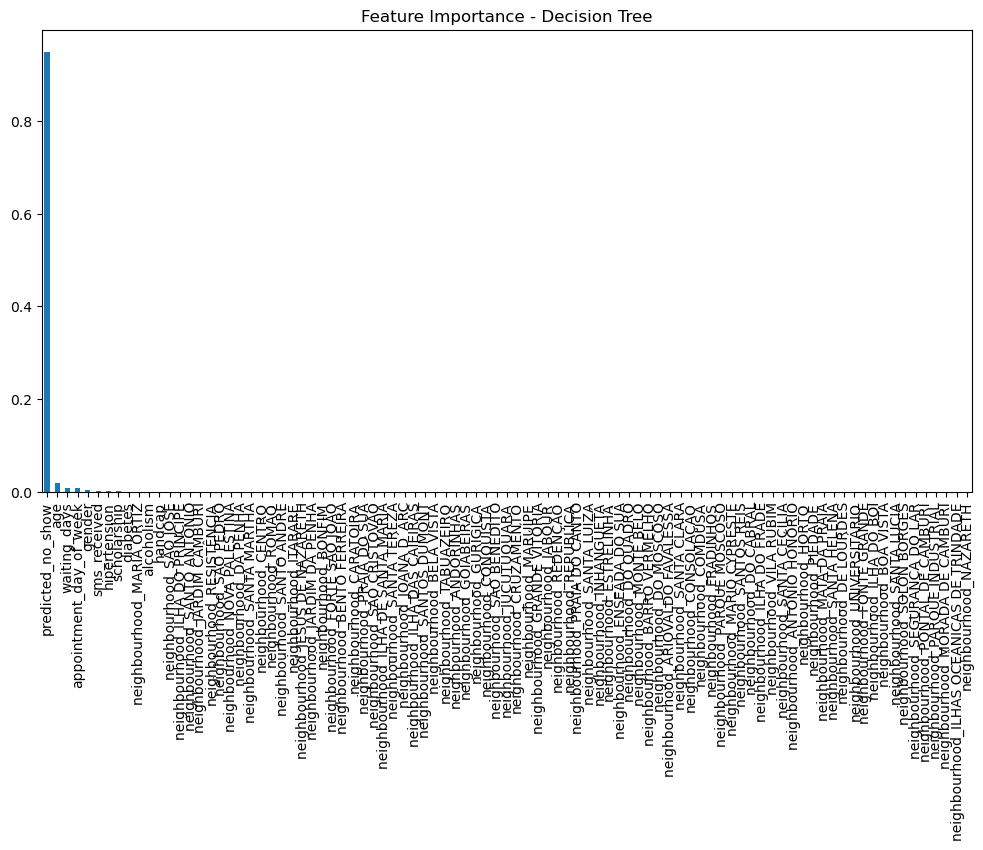

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

importances = dt_model.feature_importances_
features = X.columns

feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)
feat_imp.plot(kind='bar', figsize=(12, 6), title="Feature Importance - Decision Tree")
plt.show()


In [21]:
df['predicted_no_show'] = dt_model.predict(X)
df.to_csv("decision_tree_no_show_predictions.csv", index=False)
